In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [2]:
PATH = './'
TRAIN = './data/train/'
TEST = './data/test/'
LABELS = './data/train.csv'
SAMPLE = './data/sample_submission.csv'

In [3]:
name_label_dict = { 0: 'Nucleoplasm', 1: 'Nuclear membrane', 2: 'Nucleoli', 
                    3: 'Nucleoli fibrillar center', 4: 'Nuclear speckles', 5: 'Nuclear bodies',
                    6: 'Endoplasmic reticulum', 7: 'Golgi apparatus', 8: 'Peroxisomes',
                    9: 'Endosomes', 10: 'Lysosomes', 11: 'Intermediate filaments',
                   12: 'Actin filaments', 13: 'Focal adhesion sites', 14: 'Microtubules',
                   15: 'Microtubule ends', 16: 'Cytokinetic bridge', 17: 'Mitotic spindle',
                   18: 'Microtubule organizing center', 19: 'Centrosome', 20: 'Lipid droplets',
                   21: 'Plasma membrane', 22: 'Cell junctions', 23: 'Mitochondria',
                   24: 'Aggresome', 25: 'Cytosol', 26: 'Cytoplasmic bodies', 27: 'Rods & rings'}

In [4]:
nw = 8   #number of workers for data loader
arch = resnet34 #specify target architecture

In [5]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [6]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [7]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [8]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [9]:
bs = 64
sz = 256
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([64, 4, 256, 256]), torch.Size([64, 28]))

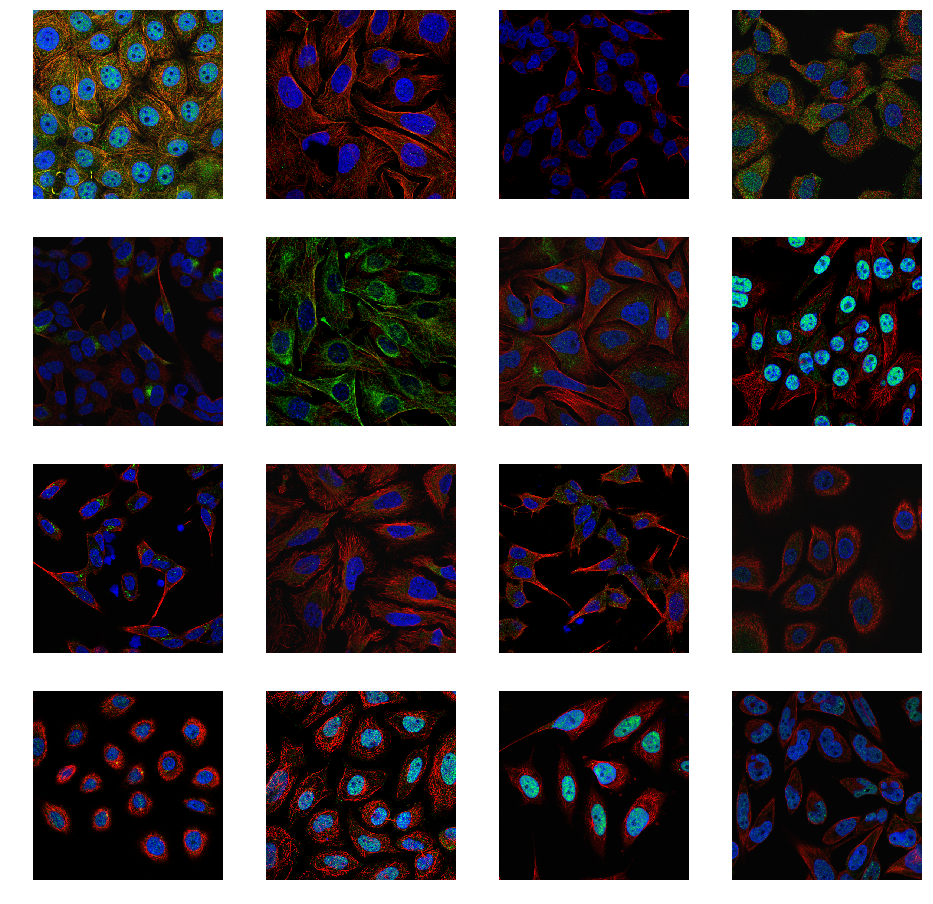

In [10]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [ ]:
x_tot = np.zeros(4)
x2_tot = np.zeros(4)
for x,y in iter(md.trn_dl):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [11]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [12]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        w = layers[0].weight
        w_ = w[:,:1,:,:].clone()
        w = torch.cat((w, w_), dim=1)
        # w = torch.cat((w,torch.zeros(64,1,7,7)),dim=1)
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(w)
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

In [13]:
sz = 256 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

In [14]:
# learner.summary

 76%|███████▋  | 333/436 [11:26<03:55,  2.29s/it, loss=9.33]

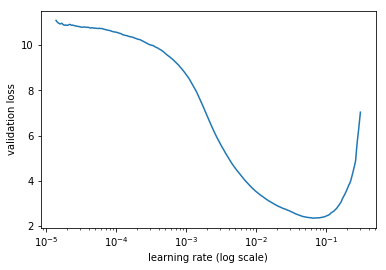

In [24]:
learner.lr_find()
learner.sched.plot()

In [17]:
lr = 2e-2
learner.fit(lr,1)

epoch      trn_loss   val_loss   acc        
    0      1.397423   1.323011   0.944314  



[1.3230107123633916, 0.9443142558310176]

In [18]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [19]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        
    0      1.016503   1.023427   0.953174  
    1      0.857964   0.788029   0.963435  
    2      0.844772   0.880118   0.959988  
    3      0.761999   0.702042   0.966917  
    4      0.794656   0.750628   0.965136  
    5      0.727176   0.665763   0.968606  
    6      0.741024   0.698836   0.966446  
    7      0.66969    0.64613    0.969204  



[0.6461301561794993, 0.9692039390021463]

In [20]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        
    0      0.741223   0.713012   0.96632   
    1      0.725776   0.674584   0.968112  
    2      0.667115   0.64495    0.969261  
    3      0.642686   0.606007   0.970594  
    4      0.723308   0.706408   0.966791  
    5      0.674758   0.729424   0.965228  
    6      0.627579   0.615596   0.970606  
    7      0.608791   0.580935   0.971985  



[0.5809350622820271, 0.9719847793591375]

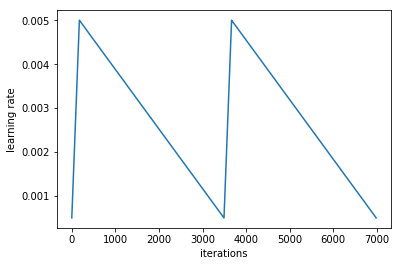

In [21]:
learner.sched.plot_lr()

In [23]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

epoch      trn_loss   val_loss   acc        
    0      0.614178   0.584818   0.972008  
    1      0.58217    0.587292   0.971387  
    2      0.570521   0.584624   0.971858  
    3      0.557962   0.58197    0.97156   
    4      0.550351   0.568152   0.972433  
    5      0.54333    0.564077   0.972743  
    6      0.529918   0.564817   0.972732  
    7      0.52909    0.558091   0.972858  



[0.5580913072387224, 0.9728581026254013]

In [24]:
learner.save('ResNet34_512_1')

In [18]:
# learner.load('ResNet34_256_1')

th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.58186 0.56576 0.57197 0.62686 0.55926 0.52376 0.50499 0.61576 0.45937 0.56994 0.61819 0.65938 0.51479
 0.50786 0.51125 0.4959  0.45148 0.51696 0.48843 0.50041 0.49771 0.49657 0.53207 0.54127 0.69964 0.52019
 0.51893 0.5    ]
F1 macro:  0.7069899671566887
F1 macro (th = 0.5):  0.6758925761642126
F1 micro:  0.7936885977969634


/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-

In [16]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [17]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [31]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.52929 0.61769 0.55595 0.49319 0.54722 0.53771 0.52611 0.55108 0.52109 0.5225  0.50629 0.49516 0.4629
 0.5907  0.58545 0.1     0.50917 0.39465 0.45935 0.5119  0.46874 0.50197 0.44225 0.52021 0.64165 0.52634
 0.47097 0.5    ]
F1 macro:  0.6531320427189374
F1 macro (th = 0.5):  0.6453886711308117
F1 micro:  0.7573466066813439


/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [32]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.45689 0.03668 0.11229 0.05116 0.06049 0.07272 0.02317 0.08687 0.00161 0.00097 0.00064 0.03282 0.01995
 0.00933 0.03057 0.04118 0.00997 0.0074  0.03185 0.04601 0.00547 0.12548 0.03089 0.09041 0.00772 0.29955
 0.01223 0.     ]
Fractions (true):  [0.41377 0.04054 0.11873 0.05277 0.05952 0.08398 0.03057 0.09299 0.00257 0.00129 0.00064 0.03539 0.02124
 0.01577 0.03121 0.00032 0.01834 0.00708 0.03378 0.04891 0.00644 0.12194 0.03089 0.09588 0.0074  0.27381
 0.01126 0.     ]


In [19]:
preds_t,y_t = learner.TTA(n_aug=16, is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [20]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [22]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [23]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y, wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [24]:
th_t = fit_test(pred_t, lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.64797 0.43446 0.63517 0.41997 0.37199 0.46919 0.40437 0.58859 0.27149 0.21485 0.17342 0.4695  0.34695
 0.47307 0.45182 0.21363 0.44301 0.5255  0.49197 0.44956 0.44742 0.55079 0.44464 0.56105 0.58272 0.609
 0.4064  0.17376]
Fractions:  [0.36336 0.04333 0.07494 0.05751 0.07264 0.07341 0.04162 0.07486 0.00931 0.00872 0.00863 0.04316 0.04162
 0.01401 0.04375 0.00795 0.02683 0.01393 0.02743 0.05726 0.00974 0.12536 0.0282  0.0752  0.00983 0.21919
 0.02786 0.00709]
Fractions (th = 0.5):  [0.52119 0.03606 0.11912 0.03982 0.03863 0.06067 0.02435 0.10588 0.00128 0.0012  0.00085 0.03751 0.01786
 0.01213 0.0382  0.      0.01726 0.01615 0.02589 0.04256 0.00564 0.16433 0.02034 0.09622 0.01444 0.39737
 0.01427 0.00009]


In [39]:
save_pred(pred_t, th_t, 'attempt_4_0_f.csv')

In [25]:
save_pred(pred_t, th, 'attempt_5_0_v.csv')
save_pred(pred_t, 0.5, 'attempt_5_0_05.csv')

In [26]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'attempt_5_0_c.csv')